## Задание 1.
Используя исторические данные на листе «Timeseries» (см. **Задания_1_2.xlsx**), построить модель временного ряда.  Спрогнозировать  ежедневное поведение ряда в следующие 3 мес.  Пояснить выбор метода прогнозирования. Привести оценки качества прогноза.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import numba
import seaborn as sns
import sklearn
import sklearn.datasets, sklearn.neighbors, sklearn.tree, sklearn.neural_network, sklearn.model_selection, \
       sklearn.preprocessing, sklearn.decomposition, sklearn.ensemble, \
       sklearn.linear_model, sklearn.pipeline, sklearn.metrics
import sklearn_pandas
import pydotplus

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
np.random.seed(33)

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 5)

Populating the interactive namespace from numpy and matplotlib


,x
Date,
2013-01-01,145
2013-01-02,1129
...,...
2016-09-29,1018
2016-09-30,1117


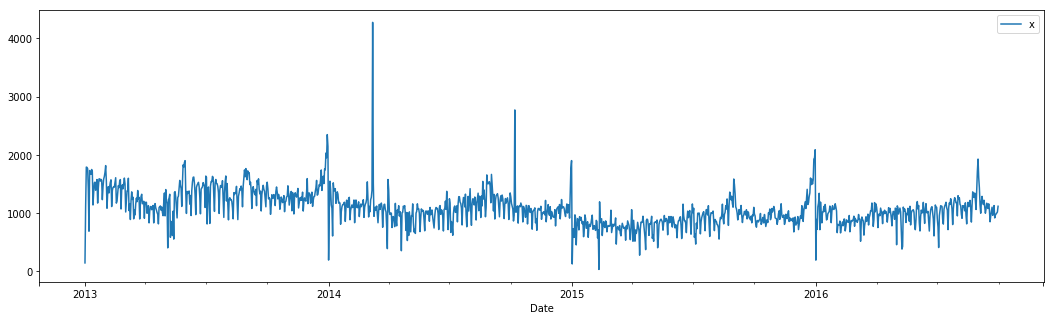

In [3]:
original_data = pd.read_excel('../inputs/Задания_1_2.xlsx', sheet_name='Timeseries', 
                              index_col='Date', parse_dates=['Date'])
original_data.rename(columns=lambda c: 'x', inplace=True)

original_data.plot()
with pd.option_context('display.max_rows', 5):
    display(original_data)

# Check if there are no gaps in dates

In [4]:
def count_gaps(data):
    d = original_data.copy()
    d.reset_index(inplace=True)
    d['Date prev'] = d['Date'].shift(1)
    d['diff'] = d['Date'] - d['Date prev']
    d['no gap'] = d['diff'] <= pd.Timedelta(1, 'D')
    return (~d['no gap']).sum() - 1
print(count_gaps(original_data))

0


# Add some features and index for future 3 month

,x,mean,dofweek name,dofweek,dofmonth,dinmonth,dtomonth,dofyear,dinyear,dtoyear,minyear
2013-01-01,145.0,1360.111111,Tuesday,1,1,31,30,1,365,364,1
2013-01-02,1129.0,1360.111111,Wednesday,2,2,31,29,2,365,363,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,NaN,NaN,Friday,4,30,31,1,365,366,1,12
2016-12-31,NaN,NaN,Saturday,5,31,31,0,366,365,-1,12


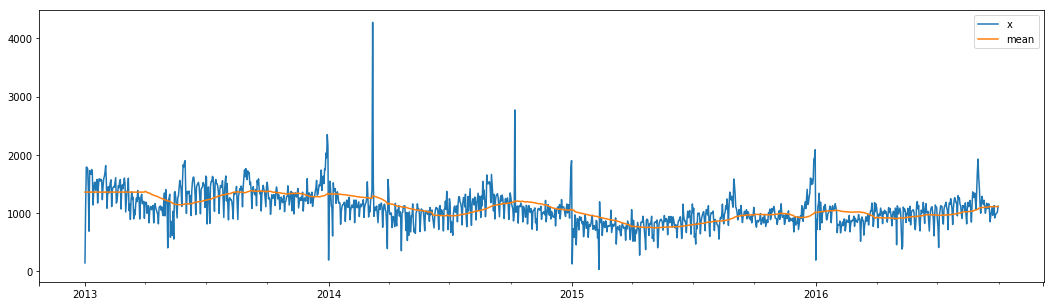

In [5]:
def add_date_props(original_data):
    data = original_data.copy()
    data['dofweek name'] = data.index.day_name()
    data['dofweek'] = data.index.dayofweek 
    data['dofmonth'] = data.index.day
    data['dinmonth'] = data.index.days_in_month
    data['dtomonth'] = data['dinmonth'] - data['dofmonth']
    data['dofyear'] = data.index.dayofyear
    data['dinyear'] = (data.index + pd.tseries.offsets.YearEnd()).dayofyear
    data['dtoyear'] = data['dinyear'] - data['dofyear']
    data['minyear'] = data.index.month
    return data
    
data = original_data.copy()
index_target = pd.DatetimeIndex(freq='1 D', start=data.index[-1] + pd.Timedelta(1, 'D'), periods=92)
data_target = pd.DataFrame(index=index_target)
data = data.append(data_target, sort=False)
window = 90
data['mean'] = data['x'].rolling(window).mean()
# data.loc[np.isnan(data['mean']), 'mean'] = data['mean'].iloc[window]
data['mean'].fillna(method='bfill', inplace=True)
data = add_date_props(data)

data[['x', 'mean']].plot()
with pd.option_context('display.max_rows', 5):
    display(data)

# Predict trend for future 3 month

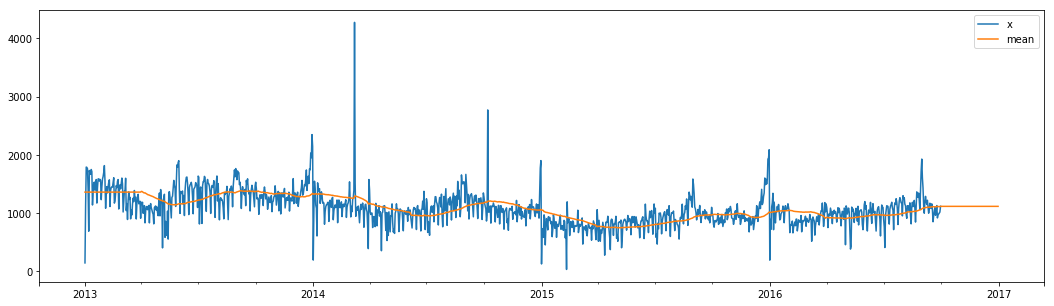

In [6]:
# mean_dtoyear = data.groupby('dtoyear', sort=True).agg({'x': np.mean})

data['mean'].fillna(method='ffill', inplace=True) # will do for now :)
data[['x', 'mean']].plot()

# Remove trend from data

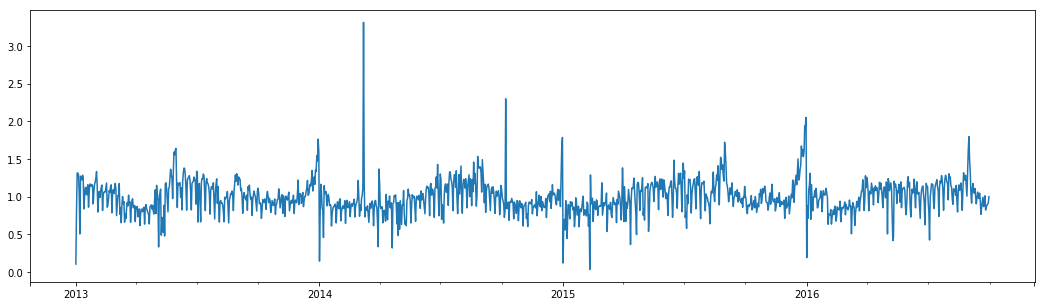

In [7]:
data['x norm'] = data['x'] / data['mean']
data = add_date_props(data)
data['x norm'].plot()

# Take a look at average by weekday

,x
dofweek name,
Tuesday,1142.897959
Wednesday,1139.821429
Thursday,1107.673469
Friday,1135.561224
Saturday,1103.533333
Sunday,851.051282
Monday,1074.856410


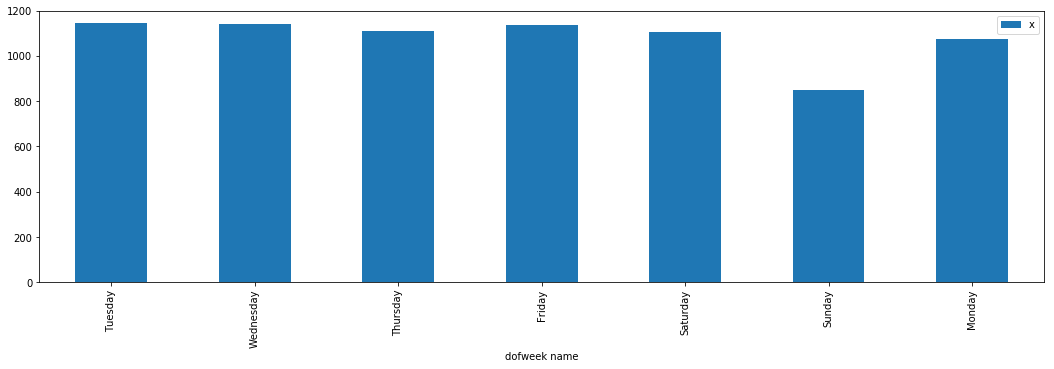

In [8]:
mean_dofweek = data.groupby('dofweek name', sort=False).agg({'x': np.mean})
display(mean_dofweek)
mean_dofweek.plot.bar()

# Get train, test data

,x,mean,dofweek name,dofweek,dofmonth,dinmonth,dtomonth,dofyear,dinyear,dtoyear,minyear,x norm
2013-01-01,145.0,1360.111111,Tuesday,1,1,31,30,1,365,364,1,0.106609
2013-01-02,1129.0,1360.111111,Wednesday,2,2,31,29,2,365,363,1,0.830079
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-28,1139.0,968.066667,Tuesday,1,28,30,2,180,366,186,6,1.176572
2016-06-29,1099.0,967.411111,Wednesday,2,29,30,1,181,366,185,6,1.136022


,x,mean,dofweek name,dofweek,dofmonth,dinmonth,dtomonth,dofyear,dinyear,dtoyear,minyear,x norm
2016-06-30,1099.0,967.377778,Thursday,3,30,30,0,182,366,184,6,1.136061
2016-07-01,900.0,966.366667,Friday,4,1,31,30,183,366,183,7,0.931324
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-29,1018.0,1111.644444,Thursday,3,29,30,1,273,366,93,9,0.915760
2016-09-30,1117.0,1115.577778,Friday,4,30,30,0,274,366,92,9,1.001275


,x,mean,dofweek name,dofweek,dofmonth,dinmonth,dtomonth,dofyear,dinyear,dtoyear,minyear,x norm
2016-10-01,NaN,1115.577778,Saturday,5,1,31,30,275,366,91,10,NaN
2016-10-02,NaN,1115.577778,Sunday,6,2,31,29,276,366,90,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,NaN,1115.577778,Friday,4,30,31,1,365,366,1,12,NaN
2016-12-31,NaN,1115.577778,Saturday,5,31,31,0,366,365,-1,12,NaN


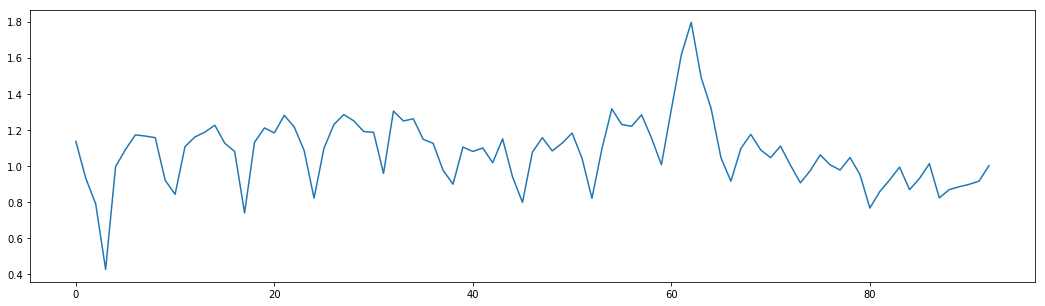

In [9]:
features = ['dofweek', 'dofmonth', 'dtomonth', 'dofyear', 'dtoyear']
target = 'x norm'

train_df = data[data.index < original_data.index[-1] - pd.Timedelta(92, 'D')]
train_x = train_df[features].values
train_y = train_df[target].values

test_df = data[(data.index <= original_data.index[-1]) & 
               (data.index >= (original_data.index[-1] - pd.Timedelta(92, 'D')))]
test_x = test_df[features].values
test_y = test_df[target].values

predict_df = data[data.index > original_data.index[-1]]
predict_x = predict_df[features]

plt.plot(test_y)
with pd.option_context('display.max_rows', 5):
    display(train_df)
    display(test_df)
    display(predict_df)

# Fit to train dataset and predict test dataset
Boosting with desicion trees works fine for timeseries predictions.

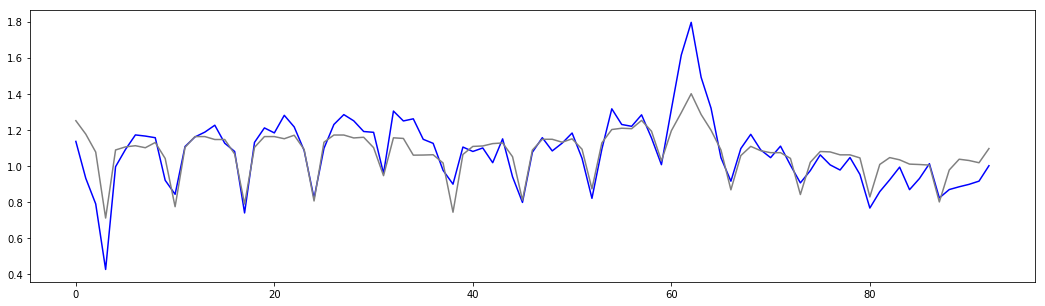

In [10]:
# base_estimator = sklearn.tree.DecisionTreeRegressor(max_depth=5)
# boost = sklearn.ensemble.AdaBoostRegressor(base_estimator=base_estimator, n_estimators=50)
boost = sklearn.ensemble.GradientBoostingRegressor()
boost.fit(train_x, train_y)

pred_test_y = boost.predict(test_x)
mserror = ((pred_test_y - test_y)**2).mean() # the plot looks good, so we don't care

plt.plot(test_y, c='blue')
plt.plot(pred_test_y, c='gray')

# Predict 3 month

,x,mean,dofweek name,dofweek,dofmonth,dinmonth,dtomonth,dofyear,dinyear,dtoyear,minyear,x norm
2016-12-27,1506.968469,1115.577778,Tuesday,1,27,31,4,362,366,4,12,NaN
2016-12-28,1745.220283,1115.577778,Wednesday,2,28,31,3,363,366,3,12,NaN
2016-12-29,1836.998472,1115.577778,Thursday,3,29,31,2,364,366,2,12,NaN
2016-12-30,1996.503512,1115.577778,Friday,4,30,31,1,365,366,1,12,NaN
2016-12-31,1988.048740,1115.577778,Saturday,5,31,31,0,366,365,-1,12,NaN


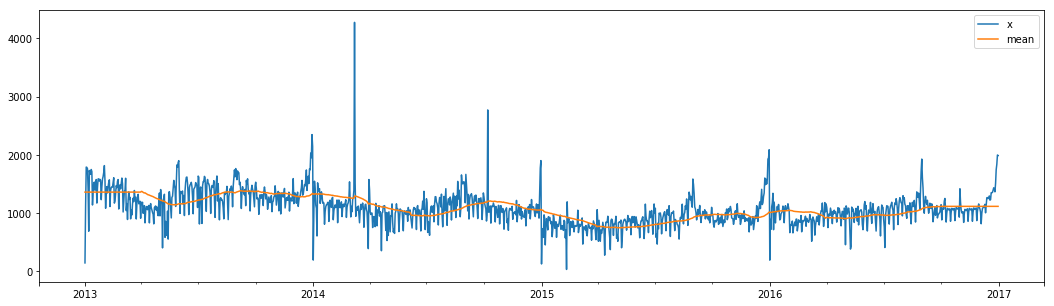

In [19]:
predict_y = boost.predict(predict_x)

predicted_df = data.copy()
predicted_df.loc[predicted_df.index > original_data.index[-1], 'x'] = predict_y * predicted_df.loc[predicted_df.index > original_data.index[-1], 'mean']
predicted_df[['x', 'mean']].plot()
display(predicted_df.tail())

In [ ]:
predicted_df['x'].to_csv('../outputs/task1.csv')

# Conclusions
- Prediction accuracy depends on a trend.
- Actual prediction accuracy will be lower than on a test dataset, because we have predicted flat trend, while there is usually a drop at the end of the year.